# **AM 207**: Homework 2

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary. 

In [4]:
# 
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# 
def Geweke(trace, intervals, length):
    nsl=length
    #
    jump = int(0.9*len(trace)/(2*intervals))
    #
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    #
    for k in np.arange(0, intervals):
        #
        baga = np.int(first+k*jump)
        #
        bagb = len(trace)/2 + k*jump
        
        #
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        #
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # 
        for i in xrange(int(0.1*nsl)):
            #
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # 
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        #
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z


# Solution written by Jeewon Hwang

## 1) How the Geweke test works and its limitations

The Geweke test compares values in the early part of the Markov chain to those in the latter part of the chain in order to detect failure of **convergence**. When we see the given code below, the statistic is constructed as follows. First, if we split the trace into 2 chunks, two subsequences of the Markov chain (**sub_trace_a** and **sub_trace_b**) are taken out, starting from the beginning of each chunk, with size of given parameter **'length'**. Therefore, in the loop there will be **'interval'** number of chunks for each (sub_trace_a, sub_trace_b). By splitting the time-series into several segements in this way, Geweke test compares the mean and variance of segements from the beginning and the end of a single chain. 

When we see our code, $\bar{\theta_a}$ and $\bar{\theta_b}$ is defined as following.

$$ \bar{\theta }_a = \frac{1}{n_1} \sum _{t=1}^{n_1} \theta_t \;  \;  \mbox{and} \;  \;  \bar{\theta }_b = \frac{1}{n_2} \sum _{t=n_ a}^{n} \theta_t $$

where $\theta_a$ index moves from $[ 1, \dots , n_1]$ and $\theta_b$ index moves from $[n_a, \dots , n]$, where $1<n_1<n_ a<n$ and $n_2 = n - n_ a + 1$.
Then, when we see the z-score formula in the given code, it is written as this, (I'll explain **n_ESS** when explaining **rhot function** at below)

$$z=\frac{\bar{\theta_a}-\bar{\theta_b}}{\sqrt{\frac{Var(\theta_a)}{n_{ESS}}+\frac{Var(\theta_b)}{n_{ESS}}}}$$

Since ratios $n_1/n$ and $n_2/n$ are fixed, then $(n_1+n_2)/n < 1$, and the chain is stationary, then the following z-score converges to a **standard normal distribution** as $n \rightarrow \infty $. That is why we can use this **z-score** as an evidence of convergence. As it will follow the standard normal distribution, **95% confidence interval** would be range from -2 to 2, therefore we say that **any value below 2 is considered convergence**.

However, Geweke test also has its own limitation. This z-score can be applied to a single sampler chain only. Also, we choose the **length** and **interval** by ourselves, this diagnostic result is subjective to the choice of the users.


(refrence : http://support.sas.com/documentation/cdl/en/statug/65328/HTML/default/viewer.htm#statug_introbayes_sect024.htm )


## 2) Write comments for the marked lines and any lines you think would be good to explain in addition. 

In [5]:
# rhot function calculates the auto-correlation coefficient of the former and latter chunk of x
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# Geweke function that tests convergence
def Geweke(trace, intervals, length):
    nsl=length
    # jump is the each chunk size
    jump = int(0.9*len(trace)/(2*intervals))
    # Geweke starts calculating from 10% of total length, and this is to cut-off the burn-in part
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    # loop to make 'interval' number of chunks 
    for k in np.arange(0, intervals):
        # the early segment starting point
        baga = np.int(first+k*jump)
        # the latter segement starting point
        bagb = len(trace)/2 + k*jump
        
        # sub trace segements extraction
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # compute the means of each segement
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # this is to cut-off the burn-in part of each chunk (we assume early 10% data as burn-in)
        for i in xrange(int(0.1*nsl)):
            # sum up auto-correlation coefficient to compute Effective Sample Size later
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # compute variance with considering Effective Sample Size
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # compute the z-score to see if our chain converges
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z

## 3) Write a short explanation of what the `rhot` function does and why it is necessary.

When we see the code for `rhot` function, it computes the **auto-correlation coefficient** for the given segement. This is computed for later use of **Effective Sample Size**.

**Effective Sample Size** is the the size of given samples that excludes the samples that are auto-correlated to each other. 

$$n_{ESS} = \frac{n}{1+2\sum_{k=1}^{\infty}\rho_k}$$

Since the traces (Markov chain) we compute for Geweke test is a kind of time-series, so each point might be correlated at different time step. Therefore, to get the size of samples that are independent, we compute auto-correlation coefficients, thereby getting Effective-Sample-Size. If auto-correlation coefficient is high, then it means our Effective-Sample-Size is small, therefore, our sample might not be able to give reliable distribution. Whereas lower auto-correlation indicates samples are more independent, therefore, it has higher efficiency and we can rely on our estimate.

# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


# Solution written by Yufeng Chen

### load data and plot histogram
Please refer to the attached code for detail. 

### Maximum likelihood of the Poisson distribtuion

Here we derive the maximum likelihood for the Poisson distribution. We have 

$P(x_i)=\frac{e^{-\lambda}\lambda^{x_i}}{x_i!}$

The likelihood is given by:

$l = \prod_{i=1}^N \frac{e^{-\lambda}\lambda^{x_i}}{x_i!}$

Equivalently we can maximize log(l). We set the derivative to 0 and obtain:

$0 = \frac{\partial logl}{\partial \lambda} = \sum_{i=1}^N (-\lambda^* + x_i\log\lambda^* - \log (x_i!))$

Simplifying the expression leads to 

$\lambda^* = \frac{\sum_{i=1}^N x_i}{N}$

We simplify calculate the mean and obtain $\lambda^* = 18.04$

### Bayesian solution and Metropolis Hasting

We choose the prior distribution to be a uniform distribution for simplicity. Here we do not have any knowledge about the possible distribution of $\lambda$. Since we have a lot of data, the power of prior diminishes as N increases. Alternatively, we also implement another prior using the normal distibution. From fitting the data, we estimate $\mu = 18$ and $\sigma=5$. We can use these values as our estimation of prior. Using this approach is controversial because we are in some sense using the data to estimate the prior. We've implemented and tested both prior and observe very similar sampled posterior. This is because the data size given in this problem is big relative to the number of parameters. To see the implementation details, please either call calc_log_posterior or calc_log_posterior_n to run with either uniform prior or normal prior. 


The posterior has the form of $p(\lambda | D) \propto p(D | \lambda) p(\lambda)$. We use Metroplis Hasting to sample from the posterior. This algorithm does not require solving for the normalization factor. 

Our implementation is based on the sample code given in the lecture notes (L08). Here we only modify minor details to account for having a lot of data. Specifically, instead of calculating the likelihood, we compute the logarithm of likelihood. When comparing the likelihood for acceptance value, we substract instead of divide. We have

$\frac{p_{next}}{p_0} = exp(ln(p_{next})-ln(p_0) = exp(ln(p_{next}-p_0))$

Please refer to the attached code for implementation details. 

We experiment with a number of step size and determine that step size = 1.3 correspond to 30% acceptance ratio. 

### convergence analysis
We use the given Geweke function and the pymc geweke function to study convergence. From visual inspection we think our MCMC implementation converges quiet quickly. However, from the Geweke convergence test we find our sampling seems to converge after around 500 samples. Please refer to the attached trace plots for details. 

###  pymc implementation
We implement an identical model using pymc. Pymc implementation does not require experimentation with the step size. The trace plots are similar in the mean. However, it seems pymc implementation has a lower acceptance rate our implemented MH. Please refer to the attached code for details.

###  posterior predictive
We superimpose posterior predictive sampling, the data and the maximum likelihood distribution. Please refer to the attached code for implementation details. Note that while the ML and posterior predictive sampling are similar, they are quiet different from the data. This suggests the Poisson likelihood may not be a good model. This suggests that we need a better likelihood function.

###  better model
We manually fit a negative binomial distribution and show that the distribution describe the data better. To solve for the parameter distribution, we use pymc to construct a model based on the negative binomial distribution. Please refer to the attached code for detail. In the end, we compare the data with the posterior predictive. Note that this comparsion is much closer, suggesting the Gamma distribution gives a better model of the system. 

number of data is:  266
lambda* is : 18.0413533835


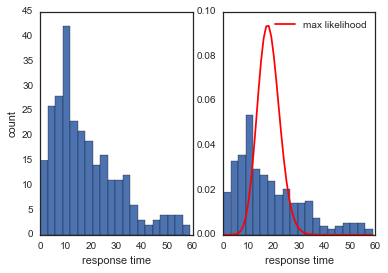

In [6]:
#load data from .csv file
data = np.genfromtxt('hangout_chat_data.csv',delimiter=',')

#print data.dtype
#assert(0)

#plot a histogram
plt.subplot(1,2,1)
plt.hist(data,bins=20)
plt.xlabel('response time')
plt.ylabel('count')

plt.subplot(1,2,2)
plt.hist(data,bins=20,normed=1)
plt.xlabel('response time')

#\lambda that corresponds to maximum likelihood is the mean 
l = np.mean(data)
print 'number of data is: ', len(data)
print 'lambda* is :', l

time_sim = np.linspace(np.min(data),np.max(data),60)
fact_terms = scipy.misc.factorial(time_sim)
p_sim = np.exp(-l) * l**time_sim / fact_terms
plt.plot(time_sim,p_sim,'r-',label = 'max likelihood')
plt.legend()


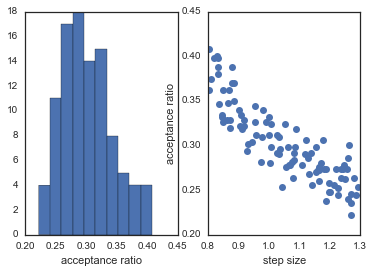

In [7]:
#metropolis hasting with a gaussian prior

#short hand for uniform random sampling
runif = np.random.rand
rnorm = np.random.normal
#short hand for normal distribution
norm = scipy.stats.norm

#define the posterior function
def calc_posterior(l,x=data):
    
    p = np.product(np.exp(-l)*l**x / scipy.misc.factorial(x) * norm.pdf(x,loc=18,scale=5))
    
    return p;

#calculate the log of posterior with uniform prior
def calc_log_posterior(l,x=data):
    p = np.sum(-l + x * np.log(l) - np.log(scipy.misc.factorial(x)));
    return p;

#calculate the log of posterior with normal prior 
def calc_log_posterior_n(l,x=data):
    p = np.sum(-l + x * np.log(l) - np.log(scipy.misc.factorial(x)) + np.log(norm.pdf(x,loc=18,scale=5)));
    return p;

def metropolis(n_iterations, init_values, step_size, doPrint = True):
    
    #determine number of parameters
    n_params = len(init_values)
    
    #initialize samples
    trace= np.empty((n_iterations+1,n_params))
    
    #set initial values
    trace[0] = init_values
    
    #calculate joint posterior for initial values
    current_prob = calc_log_posterior(*trace[0])
    
    #initialize acceptance counts
    accepted = [0]*n_params

    for i in xrange(n_iterations):
        
        if not i%10000 and doPrint:
            print 'Iterations left: ', n_iterations- i
            
        #Grab current parameter values
        current_params = trace[i]
        
        #get current value for parameter j
        p = trace[i].copy()
        
        #loop over all dimensions (here only 1 dimension)
        for j in range(n_params):
            #propose a new value
            theta = rnorm(current_params[j],step_size[j])

            #insert new value
            p[j]= theta
            
            #calculate posterior with proposed value
            proposed_prob = calc_log_posterior(*p)
            
            #acceptance rate
            alpha = proposed_prob - current_prob
            
            #sample a uniform function to determine whether to reject
            u = runif()
            
            #test proposed value
            #if (np.log(u)) < alpha:
            if u < np.exp(alpha):
                #Accept 
                trace[i+1,j]=theta
                current_prob = proposed_prob
                accepted[j] +=1
  
            else:
                #reject
                #print np.exp(alpha)
                trace[i+1,j] = trace[i,j]
                
            #update p 
            p[j] = trace[i+1,j]
            
    #print accepted
    #return samples and number of accepted steps
    return trace, accepted

#driver code to sample using metroplis-hasting and a normal prior
if __name__ =="__main__":
    n_iter = 500
    init_val = [12];
    acc_ratio = []
    step_size_vec = []
    
    for i in range(100):
        step_size = 0.8 + np.random.rand(1)*0.5 ;
        data = np.genfromtxt('hangout_chat_data.csv',delimiter=',')
        trace,acc = metropolis(n_iter,init_val,step_size,doPrint=False)
        acc_ratio.append(np.sum(acc)/np.float(n_iter))
        step_size_vec.append(step_size)
        
    acc_ratio = np.array(acc_ratio)
    
    plt.subplot(1,2,1)
    plt.hist(acc_ratio,bins=10)
    plt.xlabel('acceptance ratio')
    #print trace
    
    plt.subplot(1,2,2)
    plt.plot(step_size_vec,acc_ratio,'o')
    plt.xlabel('step size')
    plt.ylabel('acceptance ratio')
    #plot a histogram
    #plt.subplot(1,2,1)
    #plt.hist(data,bins=20)
    #plt.xlabel('response time')
    #plt.ylabel('count')

    #plt.subplot(1,2,1)
    #plt.hist(trace,bins=20,normed=True)
    #plt.xlabel('lambda')
    
    #plt.subplot(1,2,2)
    #plt.plot(trace)
    

aceptance rate = 0.320085


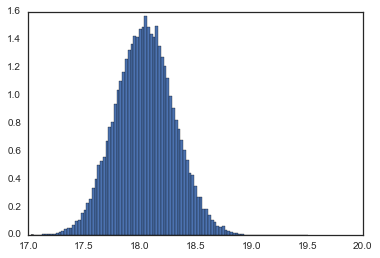

In [8]:
#trace plot and geweke test

#choose step size = 0.95
step_size = [0.95]
init_val =[12]
n_iter = 200000
trace,acc = metropolis(n_iter,init_val,step_size,doPrint=False)
print 'aceptance rate =', np.sum(acc)/np.float(n_iter)

#define burn in
burnin = 10000
l_data = trace[burnin:,0]

#histogram of alpha
fig = plt.hist(l_data,bins=100, normed=True)

(16, 20)

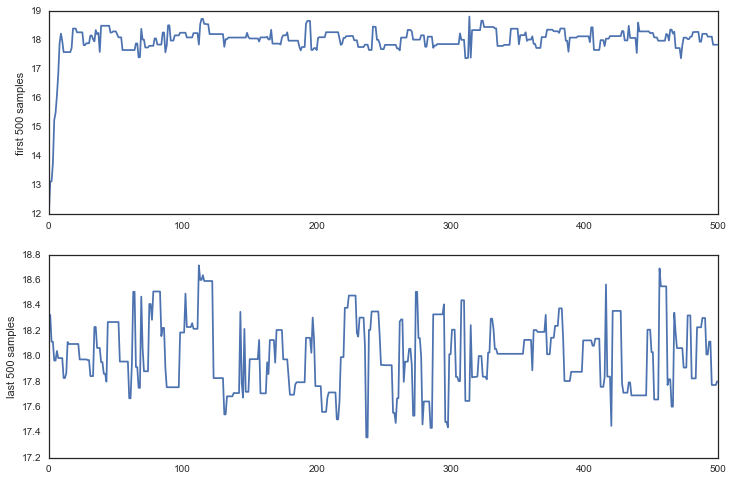

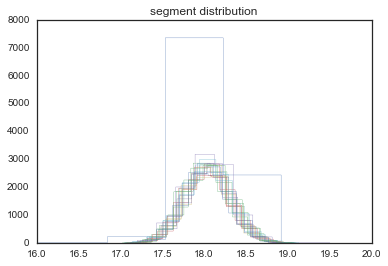

In [9]:
#trace plot
fig1 = plt.figure(figsize=[12,8])
burnin = 500

plt.subplot(2,1,1)
plt.plot(trace[:burnin,0])
plt.ylabel('first 500 samples')

plt.subplot(2,1,2)
plt.plot(trace[-burnin:,0])
plt.ylabel('last 500 samples')

fig2 = plt.figure()
plt.title('segment distribution')
subsetSize = 10000
for i in range(20):
    plt.hist(trace[subsetSize*i:subsetSize*(i+1),0],histtype='step')
    
plt.xlim([16,20])


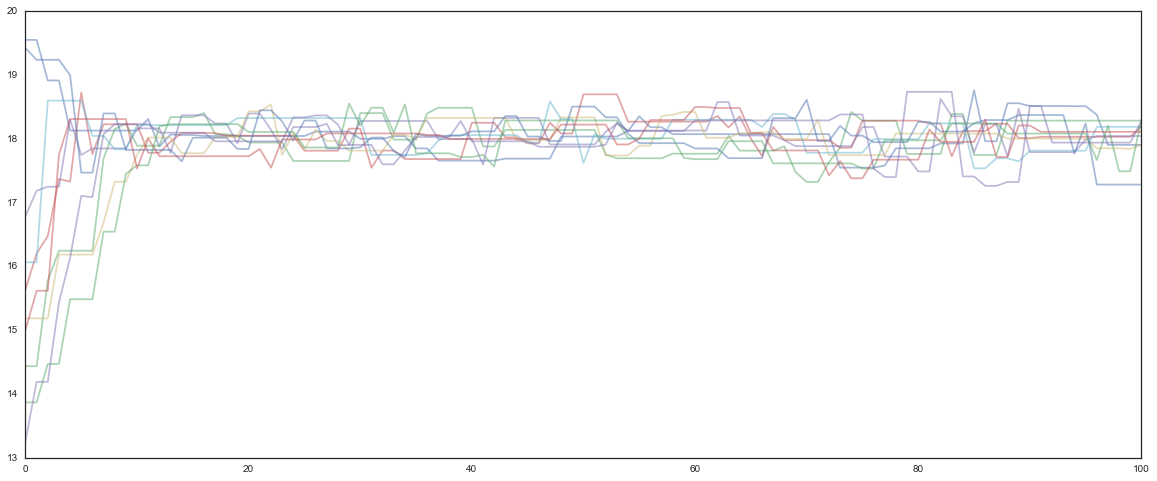

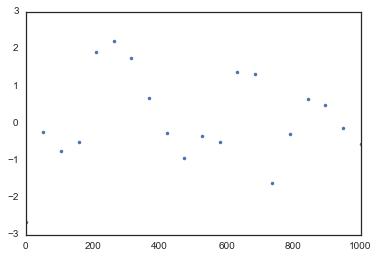

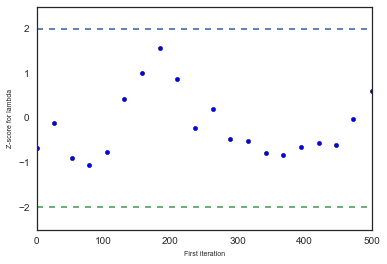

In [10]:
#comparision of multiple chain
plt.figure(figsize=[20,8])

n_iter = 100;
for i in range(10):
    start_l = np.random.rand(1)* 10 + 12.5;
    trace,acc = metropolis(n_iter,np.array(start_l),step_size,doPrint=False)
    #print trace
    plt.plot(trace[:,0],alpha=0.5)
    
#geweke test Geweke(trace, intervals, length):
num_interval = 20
num_sample = 1000
trace,acc = metropolis(num_sample,init_val,step_size,doPrint=False)
z_score = Geweke(trace[:,0],num_interval,num_sample/num_interval)
fig3= plt.figure()
#plt.title('geweke convergence test')
plt.plot(np.linspace(0,num_sample,num_interval),z_score,'.')
#plt.ylabel()
geweke_scores = pm.geweke(trace[:,0], first =0.1, last=0.5, intervals=num_interval)
pm.Matplot.geweke_plot(geweke_scores, "lambda")

 [-----------------100%-----------------] 10000 of 10000 complete in 0.4 sec

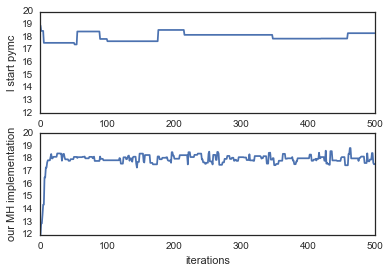

In [11]:
#solve the same problem using pymc

#load in data
data = np.genfromtxt('hangout_chat_data.csv',delimiter=',')

l = pm.Uniform('lambda',1,30) #uniform prior range from [1,30]

r_time = pm.Poisson('r_time',mu=l,value=data,observed=True)

calltime_model = pm.Model([l,r_time])
mcmc = pm.MCMC(calltime_model)

mcmc.sample(iter=10000,burn=0)



#analyze result
burnin = 500

plt.subplot(2,1,1)
plt.plot(l.trace()[:burnin])
plt.ylim(12,20)
plt.xlabel('iterations')
plt.ylabel('l start pymc')

plt.subplot(2,1,2)
plt.plot(trace[:burnin])
plt.ylim(12,20)
plt.xlabel('iterations')
plt.ylabel('our MH implementation')

#@pm.deterministic
#def likelihood_mcmc(L=l, x=data):
#    return np.exp(-L)*L**x / scipy.misc.factorial(x)



 [-----------------100%-----------------] 10000 of 10000 complete in 0.5 sec

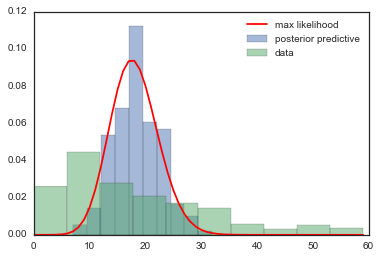

In [12]:
#posterior predictive
calltime_sim = pm.Poisson('calltime_sim',mu=l)
posterior_predictive_model = pm.Model([calltime_sim])
mcmc = pm.MCMC(posterior_predictive_model)
mcmc.sample(iter=10000,burn=1000,thin=10)

plt.hist(calltime_sim.trace(),normed=True,alpha=0.5,label= 'posterior predictive')
plt.hist(data,normed=True,alpha=0.5,label = 'data')
l_maxlike = np.mean(data)
time_sim = np.linspace(np.min(data),np.max(data),60)
fact_terms = scipy.misc.factorial(time_sim)
p_sim = np.exp(-l_maxlike) * l_maxlike**time_sim / fact_terms
plt.plot(time_sim,p_sim,'r-',label = 'max likelihood')
plt.legend()


59.0 0.0
 [-----------------100%-----------------] 10000 of 10000 complete in 2.0 sec

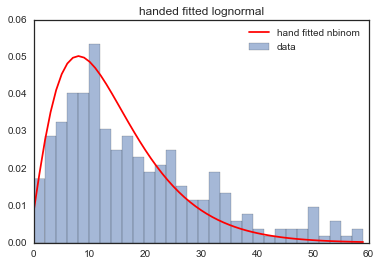

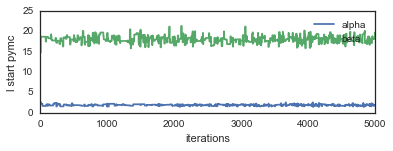

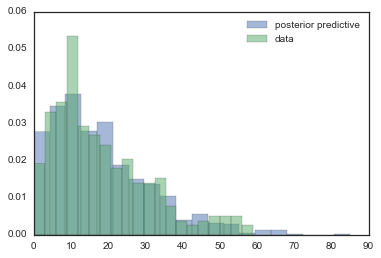

In [13]:
#better model
data = np.genfromtxt('hangout_chat_data.csv',delimiter=',')
print max(data), min(data)
plt.hist(data,bins=30,normed=True,alpha=0.5,label = 'data')
time_sim = np.linspace(np.min(data),np.max(data),60)
p_sim_negative_binomial = scipy.stats.nbinom.pmf(time_sim,2.5,0.15)
plt.plot(time_sim,p_sim_negative_binomial,'r-',label= 'hand fitted nbinom')
plt.title('handed fitted lognormal')
plt.legend()

#pymc model 
#negative binomial
alpha_mc = pm.Uniform('alpha',0,10)
mu_mc = pm.Uniform('beta',0,100)
r_time = pm.NegativeBinomial('r_time',alpha=alpha_mc,mu=mu_mc,value=data,observed=True)
calltime_model = pm.Model([alpha_mc,mu_mc,r_time])
mcmc = pm.MCMC(calltime_model)
mcmc.sample(iter=10000,burn=0)

#analyze result
burnin = 5000

fig2 = plt.figure()
plt.subplot(2,1,1)
plt.plot(alpha_mc.trace()[:burnin],label='alpha')
plt.plot(mu_mc.trace()[:burnin],label='beta')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('l start pymc')

#posterior predictive of gamma
#calltime_sim_g = pm.Gamma('calltime_sim',alpha=alpha_mc,beta=beta_mc)
calltime_sim_g = pm.NegativeBinomial('calltime_sim',alpha=alpha_mc,mu=mu_mc)
posterior_predictive_model_g = pm.Model([calltime_sim_g])
mcmc_g = pm.MCMC(posterior_predictive_model_g)
mcmc_g.sample(iter=10000,burn=1000,thin=10)

fig3 = plt.figure()
plt.hist(calltime_sim_g.trace(),bins=20,normed=True,alpha=0.5,label= 'posterior predictive')
plt.hist(data,bins=20,normed=True,alpha=0.5,label = 'data')
plt.legend()

# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



# Solution written by Kendrick Lo

<div class="alert alert-danger">
The corresponding Markov Chain is NOT irreducible, but it is aperiodic.
</div>

<div class="alert alert-info">
We have made an example of a state diagram available online at the following link: <br>
(source: Bret Victor visualization tool) <br><br> 
http://setosa.io/markov/index.html#%7B%22tm%22%3A%5B%5B0%2C0.4%2C0.6%2C0%2C0%5D%2C%5B0.65%2C0%2C0.35%2C0%2C0%5D%2C%5B0.32%2C0.68%2C0%2C0%2C0%5D%2C%5B0%2C0%2C0%2C0.12%2C0.88%5D%2C%5B0%2C0%2C0%2C0.56%2C0.44%5D%5D%7D)
</div>

<div class="alert alert-warning">
We first constructed a state diagram (also "transition graph") based on this transition matrix, which is a directed graph that allows us to picture the state transitions. If we consider each of the rows and columns of the transition matrix to be associated with the following states {A, B, C, D, E}, we can determine the probability of transitioning from one state to the other. In the graph, we note that A, B, and C are connected and can reach each other (but not themselves directly), but D and E are in a separate graph (they can reach each other, and themselves directly). 

<br><br>
The corresponding Markov chain is <strong>irreducible</strong> if it is possible to get to any state from any state. From the state diagram it is clear that states {A, B, C} cannot communicate with states {D, E}. Therefore, the corresponding Markov chain is NOT irreducible. <br><br>

The corresponding Markov chain is <strong>aperiodic</strong> i.e. if a return to any given state can occur at irregular times. In other words, there should be no deterministic loops. With respect to states {A, B, C}, each of these states can return to itself after $k$ transitions for any $k>1$. <br><br>

For example, with respect to A: {(A -> B -> A), (A -> B -> C -> A), (A -> B -> C -> B -> A), (A -> B -> C -> B -> C -> A) ...} and so on, the total number of transitions required to return to A depending on the number of transitions between B and C. The same argument can be made with respect to each of B and C. <br><br>

Similarly, with respect to states {D, E}, each of these states can return to itself after $k$ transitions for $k>=1$. For example, with respect to D: {(D -> D), (D -> E -> D), (D -> E -> E -> D), ...} and so on, the total number of transitions required to return to D depending on the number of transitions between E to itself. The same argument can be made with respect to E. <br><br>

Therefore, since there is no fixed period greater than 1 for every state, the corresponding Markov chain IS aperiodic. <br><br>

Reference: https://en.wikipedia.org/wiki/Markov_chain

</div>

# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

In [16]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

# Solution written by Wei Dai

Based on basic Bayes Theorem, we have the evidence:

$$P(x) =\int P(x | \theta)\cdot P(\theta) d\theta$$

We have discussed both in lecture and lab, the likelihood $f(x|\theta)$ of this model is a Normal distribution. Without losing geneousity, we assume the oder is 2, in which case the mean of the normal distribution is $a_0 + a_1 x + a_2 x^2$ and the standard deviation is $\sigma$. 

(Notice that here we used x to represent our data. In our problem, the data is pairs of observation(x,y).)

For a single observation $(x_i,y_i)$, the likelihood is:

$$y_i|\theta\sim \mathbf{N}\left((a_0 + a_1 x_i + a_2 x_i^2),\sigma\right)$$
meaning,

$$P(y_i|\theta)=\frac{1}{\sqrt{2\pi}\sigma}exp\left(\frac{(y_i-a_0 + a_1 x_i + a_2 x_i^2)^2}{2\sigma^2}\right)$$

Therefore our likelihood is simply product of all $f(y_i|\theta)$

$$P(x|\theta)=\prod_{i=1}^{5}\frac{1}{\sqrt{2\pi}\sigma}exp\left(\frac{(y_i-a_0 + a_1 x_i + a_2 x_i^2)^2}{2\sigma^2}\right)$$

Now back to our problem, we want to estimate $P(x)$: $$ P(x) = \int P(x | \theta)\cdot P(\theta) d \theta$$

As we have discussed in the lab, importance sampling says:
$$\int f(\theta) d \theta = \int \frac{f(\theta)}{g(\theta)} \cdot g(\theta) d \theta $$
$$\int f(\theta) d \theta = \frac{1}{N} \sum \frac{f(\theta)}{g(\theta)}$$
where $\theta$ is drawn from $g(\theta)$.

In our case, $f(\theta) = P(x|\theta) \cdot P(\theta)$, if we let $g(\theta) = P(\theta)$, then:
$$P(x) = \int f(\theta) d \theta = \frac{1}{N} \sum \frac{P(x|\theta)P(\theta)}{P(\theta)}$$
$$P(x) = \int f(\theta) d \theta = \frac{1}{N}\sum P(x|\theta)$$

This means we can directly sample $\theta$ from prior and evaluate the value at its likelihood. At the evaluation stage, we do not need to divide it by the value of prior. Thus, to estimate $P(x)$ we need to sample from $P(\theta)$ and plug in the samples in $\frac{1}{N}\sum P(x|\theta)$.

In [26]:
X_matrix=np.matrix([x**0.0,x,x**2.0,x**3.0,x**4.0]).T
sample_size=1000

total_iterations=100
evidence=np.array([np.array([0.0 for i in range(total_iterations)]) for j in range(5)])

for i in range (0,5):
    for it in range(total_iterations):
        # draw prameter theta from priors
        a_array=np.array([np.random.exponential(1,size=sample_size) for j in range(i+1)])
        epsilon=scipy.stats.invgamma.rvs(size=sample_size,a=1,scale=1)
        # calculate the mean of likelihood, by 
        mean=np.array(X_matrix[:,0:(i+1)]*a_array)
        # calculate the likelihood value
        likelihood=np.array([np.prod(scipy.stats.norm.pdf(y,loc=mean[:,j],scale=epsilon[j])) for j in range(sample_size)])
        # calculate the evidence value
        evidence[i,it]=np.mean(likelihood)
        

# Calculate mean and std
result_mean=np.array([0.0 for i in range(5)])
result_std=np.array([0.0 for i in range(5)])
for i in range (0,5):
    result_mean[i]=np.mean(evidence[i,:])
    print "For order", i, "mean is",result_mean[i]
    result_std[i]=np.std(evidence[i,:])
    print "For order", i, "standard deviation is",result_std[i]
    

For order 0 mean is 1.00365206095e-09
For order 0 standard deviation is 1.03569874002e-10
For order 1 mean is 9.56984551698e-09
For order 1 standard deviation is 1.6019477678e-09
For order 2 mean is 2.93302211849e-08
For order 2 standard deviation is 3.05444449995e-09
For order 3 mean is 1.00989062618e-08
For order 3 standard deviation is 2.56935405118e-09
For order 4 mean is 3.15462664263e-10
For order 4 standard deviation is 4.99675317347e-10


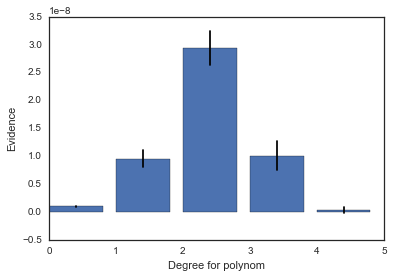

In [28]:
plt.bar(range(result_mean.shape[0]), result_mean)
for i in range(result_mean.shape[0]):
    plt.plot([i+0.4,i+0.4],[result_mean[i]-result_std[i], result_mean[i]+result_std[i]], 'k')
plt.xlabel("Degree for polynom")
plt.ylabel("Evidence")

As can be seen from the bar plot, the polynom of degree 2 is the best model for the given data. 

# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

In [31]:
# Here is the [upvote, downvote] data for 4 different videos:
video_votes = np.array([[3,0],[300,100],[2,2],[200,100]])

# Solution written by Hyungmok Son

# Part 1

I set my likelihood function as a bionomial function. For the $i^{th}$ data, the likelihood is written as:

\begin{align}
P(d_{i}|\theta_{i}) = P(n_{i}, y_{i}|\theta_{i}) = \dbinom{n_{i}}{y_{i}}\theta^{y_{i}}(1-\theta_{i})^{n_{i}-y_{i}}
\end{align}

where $\theta_{i}$ is the probability for the video to get a upvote and $y_{i}$ is the number of upvote the video gets in this $i^{th}$ data. $n_{i}$ is the total number of votes in this data for the video.

As a choice of my prior, I choose Beta distribution since this is a conjugate prior of the binomial function. Then, my prior is given by:

\begin{align}
P(\theta_{i}) = Beta(\theta_{i}, \alpha, \beta) = \frac{\theta_{i}^{\alpha-1}(1-\theta_{i})^{\beta-1}}{B(\alpha, \beta)}
\end{align}

where $\alpha$ and $\beta$ are the parameter variables. Then, my posterior is:

\begin{align}
P(\theta|D) \propto \prod_{i} Beta(\theta_{i}, \alpha + y_{i}, \beta + n_{i} - y_{i}) 
\end{align}

For the case when people in general are undecided about video, I can change my prior as Uniform distribution by setting the variables, $\alpha = \beta = 1.$ In this case, my posterior becomes proportional to $\prod_{i} Beta(\theta_{i}, 1 + y_{i}, 1 + n_{i} - y_{i})$ with a mean of the parameter, $\bar{\theta_{i}} = (1+y_{i})/(2+n_{i}).$
For the case where people are opiniated so that, for instance, they are higly likely to upvote for this video, I can set $\alpha = 10, \beta = 1$ and this gives a posterior proportional to $\prod_{i} Beta(\theta_{i}, 10 + y_{i}, 1 + n_{i} - y_{i})$ with a mean of the parameter $(10+y_{i})/(11+n_{i}).$

The below is the plot that shows the posterior of each hypothetical case for the given four videos. As I predicted, the choise of prior affects the mean of my posterior. On top of that, other quantities such as variance, skewness, etc that are functions of variables $\alpha, \beta$ also possibly changes upon the choice of my prior (in this case, parameter variables $\alpha, \beta$).

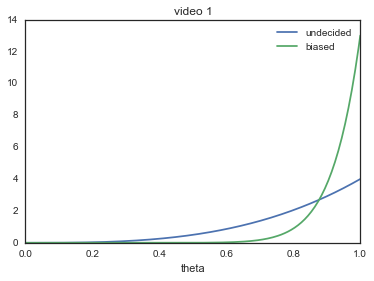

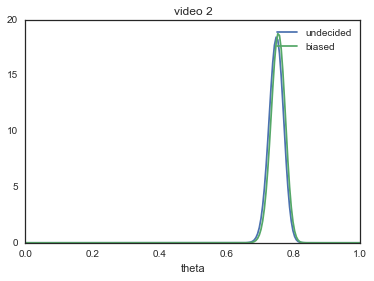

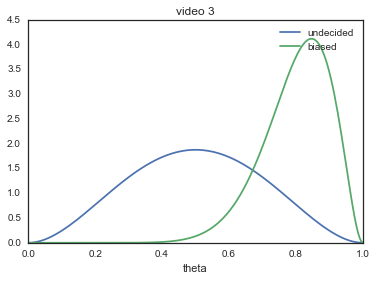

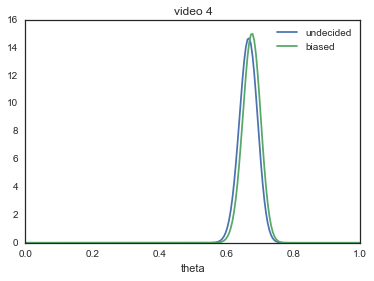

In [32]:
b = scipy.stats.beta
alpha1 = beta1 = 1
alpha2 = 10; beta2 = 1;

theta = np.linspace(0.0, 1.0, 200)
for i in np.arange(len(video_votes)):
    down = video_votes[i][1]
    up = video_votes[i][0]
    
    plt.figure(i)
    plt.title('video %s' %(i+1))
    plt.xlabel('theta')
    plt.plot(theta, b.pdf(theta, alpha1 + up, beta1 + down), label='undecided')
    plt.plot(theta, b.pdf(theta, alpha2 + up, beta2 + down), label='biased')
    plt.legend()
    

# Part 2
Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

In [33]:
N = 100000 ## the number of samples

## unbiased case
unbPercent =[]
for i in np.arange(len(video_votes)):
    down = video_votes[i][1]
    up = video_votes[i][0]

    theta1 = scipy.stats.beta.rvs(alpha1 + up, beta1 + down, size=N)
    unbPercent.append(np.percentile(theta1, 5))
#     plt.figure(i)
#     plt.hist(theta1, bins=100, normed=True)

## biased case
bPercent =[]
for i in np.arange(len(video_votes)):
    down = video_votes[i][1]
    up = video_votes[i][0]

    theta2 = scipy.stats.beta.rvs(alpha2 + up, beta2 + down, size=N)
    bPercent.append(np.percentile(theta2, 5))
#     plt.figure(i)
#     plt.hist(theta2, bins=100, normed=True)

for j in np.arange(len(video_votes)):
    print "5 percentile for videio %s in the unbiased case: %s" %(j+1, round(unbPercent[j], 6))

print "Rank: 2 / 4 / 1 / 3"

print "---------------------------------------------------------"
for j in np.arange(len(video_votes)):
      print "5 percentile for videio %s in the biased case: %s" %(j+1, round(bPercent[j], 6))

print "Rank: 1 / 2 / 4 / 3"

5 percentile for videio 1 in the unbiased case: 0.471555
5 percentile for videio 2 in the unbiased case: 0.712543
5 percentile for videio 3 in the unbiased case: 0.191744
5 percentile for videio 4 in the unbiased case: 0.620462
Rank: 2 / 4 / 1 / 3
---------------------------------------------------------
5 percentile for videio 1 in the biased case: 0.793628
5 percentile for videio 2 in the biased case: 0.718646
5 percentile for videio 3 in the biased case: 0.615637
5 percentile for videio 4 in the biased case: 0.630764
Rank: 1 / 2 / 4 / 3


As we see above, when people are very opniated againt downvoting for the videos, the rank based on the 5th percentile changes. When the number of cases (i.e. y and n) are large enough compared to $\alpha, \beta$ so that the posterior distribution quantities (such as mean, variance, etc) are not affected heavily upon $\alpha, \beta$, the posterior is more or less similar in biased and unbiased cases; this is the case for video 2 and 4. However, since the number of cases for videos 1 and 3 are so small compared to $\alpha, \beta$, the posterior becomes significantly different in biased and unbiased cases. In particular, I chose $\alpha, \beta$ that represent the case where people are highly opniated against downvoting for the videos, the left tail of the posterior significantly decreases for video 1 and 3; this is why 5 percentiles for video 1 and 3 increase significantly in the biased case. By considering the posterior for the unbiased case with given the data, we see that such change in video 1 is large enough to put video 1 on the first rank in the biased case. 

In this biased case I simulated with given data, 95 percentile instead of 5 percentile would be a better indicator of the rank. See the below result:

In [34]:
## unbiased case
unbPercent =[]
for i in np.arange(len(video_votes)):
    down = video_votes[i][1]
    up = video_votes[i][0]

    theta1 = scipy.stats.beta.rvs(alpha1 + up, beta1 + down, size=N)
    unbPercent.append(np.percentile(theta1, 95))
#     plt.figure(i)
#     plt.hist(theta1, bins=100, normed=True)

## biased case
bPercent =[]
for i in np.arange(len(video_votes)):
    down = video_votes[i][1]
    up = video_votes[i][0]

    theta2 = scipy.stats.beta.rvs(alpha2 + up, beta2 + down, size=N)
    bPercent.append(np.percentile(theta2, 95))
#     plt.figure(i)
#     plt.hist(theta2, bins=100, normed=True)

for j in np.arange(len(video_votes)):
    print "5 percentile for videio %s in the unbiased case: %s" %(j+1, round(unbPercent[j], 6))

print "Rank: 1 / 3 / 2 / 4"

print "---------------------------------------------------------"
for j in np.arange(len(video_votes)):
      print "5 percentile for videio %s in the biased case: %s" %(j+1, round(bPercent[j], 6))

print "Rank: 1 / 3 / 2 / 4"

5 percentile for videio 1 in the unbiased case: 0.987605
5 percentile for videio 2 in the unbiased case: 0.783607
5 percentile for videio 3 in the unbiased case: 0.809369
5 percentile for videio 4 in the unbiased case: 0.709529
Rank: 1 / 3 / 2 / 4
---------------------------------------------------------
5 percentile for videio 1 in the biased case: 0.996064
5 percentile for videio 2 in the biased case: 0.788535
5 percentile for videio 3 in the biased case: 0.938722
5 percentile for videio 4 in the biased case: 0.718234
Rank: 1 / 3 / 2 / 4


In conclustion, we need to choose an appropriate, better indicator of the rank considering the characteristics of the simulated bias (i.e. the choice of prior) and how the given data would vary upon the choice of prior.